# Run GLMS

only uswed one hand, so no contralateral-ipsilateral responses

In [1]:
# import os
# os.environ['OPENBLAS_NUM_THREADS'] = '1'
# os.environ['MKL_NUM_THREADS'] = '1'
# os.environ['NUMEXPR_NUM_THREADS'] = '1'
# os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import numpy as np
import shutil
import itertools
# import statannot

import glob
import re
import seaborn as sns
import statsmodels.api as sm
import statsmodels
import scipy
import nideconv
from nideconv import GroupResponseFitter
from scipy import signal

import pickle as pkl
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.backends.backend_pdf

%matplotlib inline

def flatten(t):
    return [item for sublist in t for item in sublist]

/home/stevenm/miniconda3/lib/python3.9/site-packages/nilearn/input_data/__init__.py:27: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


## functions

In [2]:
def to_psc(x): # calculate percent signal change
    return x / x.mean() * 100 - 100

def load_events_confounds(sub, dataset, task, run, include_physio=True, include_cosines=True):
    event_fn = f'../derivatives/event_files/{dataset}/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_events.tsv'
#    regressor_fn = f'../derivatives/behavior/sub-{sub}/ses-{ses}/func/sub-{sub}_ses-{ses}_task-{task}_run-{run}_desc-model-regressors.tsv'
    confounds_fn = f'../derivatives/fmriprep/{dataset}/fmriprep/fmriprep/sub-{sub}/func/sub-{sub}_task-{task}_run-{run}_desc-confounds_timeseries.tsv'
    
    events = pd.read_csv(event_fn, sep='\t', index_col=None)
    events['duration'] = .001
            
    # get confounds, cosines
    confounds = pd.read_csv(confounds_fn, sep='\t').fillna(method='bfill')
    include_confs = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z', 'dvars', 'framewise_displacement', 'global_signal']
    if include_cosines:
        include_confs += [x for x in confounds.columns if 'cos' in x]
    confounds = confounds[include_confs]
    
    if include_physio:
        run_idx = run#+1
        # just use acompcor
        a_comp_cor = pd.read_csv(confounds_fn, sep='\t')[['a_comp_cor_' + str(x).zfill(2) for x in range(20)]]
        confounds = pd.concat([confounds, a_comp_cor], axis=1)

    return events, confounds

def load_timeseries(atlas_type='MASSP', dataset='Leipzig_7T_SM', task='msit'):

    signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-*/func/*task-{task}*{atlas_type}-signals*.tsv'))

    regex = re.compile(f'.*sub-(?P<sub>\d+)_task-{task}_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
    dfs = []
    for signal_fn in signal_fns:
        signals = pd.read_csv(signal_fn, sep='\t')
        gd = regex.match(signal_fn).groupdict()

        if 'time' in signals.columns:
            signals = signals.rename(columns={'time': 'volume'})


        signals = signals.set_index(['volume']).apply(to_psc).reset_index()  # to PSC
        signals['time'] = signals['volume'] * 1.38

        del signals['volume']
        signals['sub'] = gd['sub']
        signals['run'] = int(gd['run'])
        signals = signals.set_index(['sub', 'run', 'time'])
        dfs.append(signals)

    df = pd.concat(dfs)
    
    return df

def sort_data(df, ses, task):
    
    all_events = []
    all_confounds = []

    for sub, run in df.reset_index().set_index(['sub', 'run']).index.unique():
    #     if sub == '010' and run == '2':    # no RETROICOR
    #         continue
#         if sub == '007' and run == '1':    # no RETROICOR
#             continue
        events, confounds = load_events_confounds(sub, ses, task, run, include_physio=True)
        events['sub'] = sub
        events['run'] = run
        confounds['sub'] = sub
        confounds['run'] = run

        all_events.append(events)
        all_confounds.append(confounds)

    events = pd.concat(all_events).set_index(['sub', 'run'])
    confounds = pd.concat(all_confounds).set_index(['sub', 'run'])

    events = events.rename(columns={'trial_type': 'event_type'})

    events['duration'] = 0.001  # stick function
        
    # make psc
    confounds['global_signal'] = (confounds['global_signal']-confounds['global_signal'].mean())/confounds['global_signal'].std()

    # change subject number ordering
    subs = df.reset_index()['sub'].unique()
    mapping = {y:x+1 for x,y in enumerate(subs)}

    events = events.reset_index()
    events['sub'] = events['sub'].replace(mapping).astype(str)
    events = events.set_index(['sub', 'run'])

    df = df.reset_index()
    df['sub'] = df['sub'].replace(mapping).astype(str)
    df = df.set_index(['sub', 'run', 'time'])

    confounds = confounds.reset_index()
    confounds['sub'] = confounds['sub'].replace(mapping).astype(str)
    confounds = confounds.set_index(['sub', 'run'])

    events.index = events.index.rename('subject', level=0)
    df.index = df.index.rename('subject', level=0)
    confounds.index = confounds.index.rename('subject', level=0)
    
    return events, df, confounds


In [3]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

## start running

In [4]:
# which dataset?
# dataset = 'Leipzig_7T_SM'
# dataset = 'Leipzig_7T_GdH'
# dataset = 'NTNU_7T_SJSI'
dataset = 'aron_3T'

In [5]:
if dataset == 'Leipzig_7T_GdH':
    task = 'stop'
    t_r = 2.0
    runs = [1,2,3]
    excluded_runs = [('GAIT', '2'),
                 ('GAIT', '3'),
                 ('NM3T', '2'),
                 ('PF5T', '1')]
    
elif dataset == 'Leipzig_7T_SM':
    task = 'stop'
    t_r = 3.0
    runs = [1,2,3]
    excluded_runs = []
    
elif dataset == 'NTNU_7T_SJSI':
    task = 'sst'
    t_r = 1.38
    runs = [1,2]
    excluded_runs = []
    
elif dataset == 'aron_3T':
    task = 'stopsignal'
    t_r = 2.0
    runs = [1,2,3]
    excluded_runs = []

In [6]:
# collect together all regions of interest for each sub.
subs = [x.split('/')[-1].split('-')[-1] for x in glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-*')]
print(len(subs)) 

# for hp in ['','_hp']:
#     for sub in subs:
#     #     print(sub)
#         for run in runs:
#     #         print(run)
#             all_sigs = []#pd.DataFrame()
#             signals = sorted(glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-{sub}/func/*task-{task}_run-{run}*-signals{hp}.tsv'))
#             if signals == []:
#                 print(f'no data for sub {sub} run {run} task {task}')
#                 continue
#             signals = [x for x in signals if 'ALL' not in x]
#             for index, sig in enumerate(signals):
#                 if index == 0:
#                     all_sigs = pd.read_csv(sig, sep='\t')
#                 else:
#                     all_sigs = pd.concat([all_sigs, pd.read_csv(sig, sep='\t')],axis=1)

#             all_sigs = all_sigs.loc[:,~all_sigs.columns.duplicated()]
#             all_sigs.to_csv(sig.replace('harvard','ALL'),'\t') # replace last loaded mask name with ALL


14


In [16]:
## Load timeseries
atlas_type = 'useful'
signal_fns = sorted(glob.glob(f'../derivatives/extracted_signals/{dataset}/sub-*/func/*task-{task}*{atlas_type}*signals.tsv'))
# signal_fns = [x for x in signal_fns if not any(s in x for s in to_remove)] # remove subs that didnt do task right
signal_fns

filter_out_confounds = True
filter_hp = False # already highpassed so no need

regex = re.compile(f'.*sub-(?P<sub>[a-zA-Z0-9]+)_task-(?P<task>\S+)_run-(?P<run>\d)_desc-{atlas_type}-signals.tsv')
dfs = []
for signal_fn in signal_fns:
    signals = pd.read_csv(signal_fn, sep='\t',index_col=0)
    signals = signals.loc[:, ~signals.columns.str.contains('^Unnamed')]
    gd = regex.match(signal_fn).groupdict()
#     print(tuple(gd.values()))
    if tuple(gd.values()) in excluded_runs:
        # run was excluded
        print(tuple(gd.values()))
        continue
    
    if 'time' in signals.columns:
        # if there's a column named 'time', it's called 'time' but it's really volume number..
        signals = signals.rename(columns={'time': 'volume'})
    if 'volume' in signals.columns:
        signals = signals.set_index('volume')
#     print(signals)
    # psc?
    signals = signals.apply(to_psc)  # to PSC
#     print(signals)

    # filter out confounds?
    if filter_out_confounds:
        _, confounds = load_events_confounds(sub=gd['sub'], dataset=dataset, task=gd['task'], run=gd['run'])
        confounds['intercept'] = 1   # add intercept!
        betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
        signals_hat = confounds@betas
        signals_hat.index = signals.index
        signals_hat.columns = signals.columns
        signals -= signals_hat   # residuals
        
    # high pass?
    if filter_hp:
        signals = signals.apply(lambda x: butter_highpass_filter(x, cutoff=1/128, fs=1/t_r) + x.mean(), axis=0)
    
    # index to time
    signals.index *= t_r
    signals.index.name = 'time'
    signals['subject'] = gd['sub']
    signals['run'] = int(gd['run'])
        
    signals = signals.reset_index().set_index(['subject', 'run', 'time'])
    dfs.append(signals)
df = pd.concat(dfs)
df = df.reindex(sorted(df.columns), axis=1)

if atlas_type == 'ALL':
    df.rename(columns = {'lM1':'M1-l', 'rM1':'M1-r', 'gpel':'GPe-l','gper':'GPe-r','gpil':'GPi-l','gpir':'GPi-r',
                         'rnl':'RN-l','rnr':'RN-r','snl':'SN-l','snr':'SN-r','stnl':'STN-l','stnr':'STN-r',
                         'strl':'Str-l','strr':'Str-r','thal':'Tha-l','thar':'Tha-r','vtal':'VTA-l','vtar':'VTA-r'}, inplace = True)
#     rois_ = sorted(['IFG-l','IFG-r','ACC-l','ACC-r','M1-l','M1-r','SMA-l','SMA-r','PaCG-l','PaCG-r','Ins-l','Ins-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
#              'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r'])
#     rois_ = ['ACC-l','ACC-r','IFG-l','IFG-r','Ins-l','Ins-r','M1-l','M1-r','pSG-l','pSG-r','SMA-l','SMA-r','SPL-l','SPL-r','GPe-l','GPe-r','GPi-l','GPi-r','RN-l','RN-r','SN-l','SN-r',
#              'STN-l','STN-r','Str-l','Str-r','Tha-l','Tha-r','VTA-l','VTA-r']
    
    rois_ = ['IFG','SMA','M1','SN','STN','GPe','Tha']
    rois_ = [roi + '-' + hemi for roi in rois_ for hemi in ['l', 'r']]
    # all cortical masks from harvard-oxford atlas
    # all subcortical masks from MASSP atalas
    df = df[rois_]
    
elif atlas_type == 'ATAG':
    rois_ = ['lM1','rM1','lPreSMA','rPreSMA','rIFG','lSTN','rSTN','lSN','rSN']#,'ACC','THA']
    df = df[rois_]
    
# os.makedirs(timeseries_dir:=f'../derivatives/hierarchical_roi_glm/{dataset}/timeseries', exist_ok=True)
# with open(os.path.join(timeseries_dir, f'{dataset}_timeseries.pkl'), 'wb') as f:
#             pkl.dump('', f)
# with open(os.path.join(timeseries_dir, f'{dataset}_timeseries.pkl'), 'wb') as f:
#             pkl.dump(df, f)

df.head()

/tmp/ipykernel_109772/3115124446.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_109772/3115124446.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  betas, residuals, rank, s, = np.linalg.lstsq(a=confounds, b=signals)
/tmp/ipykernel_109772/3115124446.py:36: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default 

Caudate-l  Caudate-r     IFG-l     IFG-r      M1-l  \
subject run time                                                       
01      1   0.0   -0.235038  -0.215519  0.214856  0.081522 -0.144064   
            2.0   -0.155146   0.172080 -0.033094 -0.168227  0.050407   
            4.0    0.132113   0.207533  0.038720 -0.041997 -0.007105   
            6.0    0.176467   0.046223 -0.402412  0.020263  0.210945   
            8.0    0.153899   0.021541  0.155458  0.151219  0.222763   

                      M1-r  Putamen-l  Putamen-r     gpe-l     gpe-r  ...  \
subject run time                                                      ...   
01      1   0.0  -0.008564  -0.045418   0.033128  0.071612 -0.031677  ...   
            2.0  -0.081357  -0.083059  -0.110484 -0.128537 -0.164898  ...   
            4.0   0.005556  -0.379654  -0.153967 -0.171572  0.035709  ...   
            6.0   0.194307  -0.067484  -0.019839  0.230707 -0.018644  ...   
            8.0   0.021785  -0.088635  -0.355762  0.083447 -0.081353  ...   

                  preSMA-l  preSMA-r      sn-l      sn-r     stn-l     stn-r  \
subject run time                                                               
01      1   0.0  -0.012782  0.091240 -0.070542 -0.800309 -0.060108 -0.468800   
            2.0  -0.122159  0.068289 -0.497137  0.388075  0.294781  0.102425   
            4.0  -0.294534 -0.217440  0.207240  0.784731 -0.142960 -0.163530   
            6.0   0.064121 -0.097369  0.012987  0.266470 -0.888432  0.126214   
            8.0   0.087378 -0.095033  0.092044  0.054872 -0.043016  0.316187   

                     tha-l     tha-r     vta-l     vta-r  
subject run time                                          
01      1   0.0  -0.040117 -0.050272 -0.278086 -0.065781  
            2.0   0.007503 -0.030721 -0.190085 -0.165699  
            4.0   0.064351 -0.260246 -0.082477 -0.471312  
            6.0   0.126013 -0.159702  0.158381  0.246743  
            8.0  -0.073165 -0.139236  0.364174  0.117952  

[5 rows x 22 columns]

## load event, confounds

In [17]:
model_n = 'all_events'
all_events = []
all_confounds = []

for sub, run in df.reset_index().set_index(['subject', 'run']).index.unique():
    events, confounds = load_events_confounds(sub, dataset, task, run, include_physio=True)
    events['subject'] = sub
    events['run'] = run
    confounds['subject'] = sub
    confounds['run'] = run
    
    all_events.append(events)
    all_confounds.append(confounds)
    
events = pd.concat(all_events).set_index(['subject', 'run'])
confounds = pd.concat(all_confounds).set_index(['subject', 'run'])

events = events.rename(columns={'trial_type': 'event_type'})

events['duration'] = 0.001  # stick function

# os.makedirs(event_dir:=f'../derivatives/hierarchical_roi_glm/{dataset}/events', exist_ok=True)
# with open(os.path.join(event_dir, f'{dataset}_events.pkl'), 'wb') as f:
#             pkl.dump('', f)
# with open(os.path.join(event_dir, f'{dataset}_events.pkl'), 'wb') as f:
#             pkl.dump(events, f)
        
# os.makedirs(confound_dir:=f'../derivatives/hierarchical_roi_glm/{dataset}/confounds', exist_ok=True)
# with open(os.path.join(confound_dir, f'{dataset}_confounds.pkl'), 'wb') as f:
#             pkl.dump('', f)
# with open(os.path.join(confound_dir, f'{dataset}_confounds.pkl'), 'wb') as f:
#             pkl.dump(confounds, f)

## glm function

In [18]:
def fit_glm(timeseries, events, confounds, include_events, include_rois, t_r=t_r, oversample_design_matrix=10, concatenate_runs=False, fit_type='ols'):
    events_1 = events.reset_index().set_index(['subject', 'run', 'event_type']).loc[(slice(None), slice(None), include_events),:]
    events_1 = events_1.reset_index().set_index(['subject', 'run', 'event_type'])
    events_1.onset -= t_r/2   # stc

    glm1 = GroupResponseFitter(timeseries.copy()[include_rois],
                               events_1, 
                               confounds=confounds.copy().reset_index() if confounds is not None else None,
                               input_sample_rate=1/t_r, 
                               oversample_design_matrix=oversample_design_matrix,
                               concatenate_runs=concatenate_runs)
    for event_type in include_events:
#         if event_type in ['stimulus_value_difference', 'feedback_PE']:
#             glm1.add_event(event_type, covariates='modulation', basis_set='canonical_hrf', interval=[0, 19.32])
#         else:
        glm1.add_event(event_type, basis_set='canonical_hrf_with_time_derivative',  interval=[0, 20])

    glm1.fit(type=fit_type)
    return glm1

# fit event glm

In [19]:
if atlas_type == 'ALL':
    gm_nuclei = ['IFG','SMA','M1','SN','STN','GPe','Tha']
    include_rois = [roi + '-' + hemi for roi in gm_nuclei for hemi in ['l', 'r']]

# include_events=['response_left','response_right','fs','ss','go']
include_rois = [x for x in df.columns]
include_events = ['fs','ss','go']
confounds = None
glm1 = fit_glm(timeseries=df, events=events, confounds=confounds, include_events=include_events, include_rois=include_rois)

/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/group_analysis.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  self.response_fitters = pd.Series(index=index)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  self.X = pd.concat((regressor.X, self.X), 1)
/home/stevenm/miniconda3/lib/python3.9/site-packages/nideconv/response_fitter.py:91: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keywo

In [28]:
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs', 'ss'], 'intercept', 'HRF')]                  # Select only betas of interest
#subjectwise_betas.loc[(slice(None),'fs','intercept','HRF')]
roiwise_betas = subjectwise_betas.loc[(slice(None),slice(None),'intercept','HRF')]
roiwise_betas = roiwise_betas.reset_index().melt(id_vars=['subject', 'event type'], var_name='ROI', value_name='cope')
roiwise_betas['roi_nohemi'] = roiwise_betas['ROI'].apply(lambda x: x.split('-')[0])
roiwise_betas['hemisphere'] = roiwise_betas['ROI'].apply(lambda x: x.split('-')[1])
roiwise_betas['roi_nohemi'] = roiwise_betas['roi_nohemi'].replace({'gpi': 'GPi', 
                                                                   'gpe': 'GPe', 
                                                                   'SMA': 'preSMA', 
                                                                   'sn':'SN', 'stn':'STN', 'm1':'M1', 'preSMA':'SMA', 'tha':'Tha', 'vta':'VTA'})
roiwise_betas['ROI'] = roiwise_betas['roi_nohemi'] + '-' + roiwise_betas['hemisphere']
roiwise_betas['dataset'] = 'aron_3T'
roiwise_betas.to_csv('../derivatives/copes_roi_analysis_nideconv_aron.tsv', sep='\t', index=False)

In [27]:
roiwise_betas['ROI'].unique()

array(['Caudate-l', 'Caudate-r', 'IFG-l', 'IFG-r', 'M1-l', 'M1-r',
       'Putamen-l', 'Putamen-r', 'GPe-l', 'GPe-r', 'GPi-l', 'GPi-r',
       'SMA-l', 'SMA-r', 'SN-l', 'SN-r', 'STN-l', 'STN-r', 'THA-l',
       'THA-r', 'VTA-l', 'VTA-r'], dtype=object)

/home/stevenm/miniconda3/lib/python3.9/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


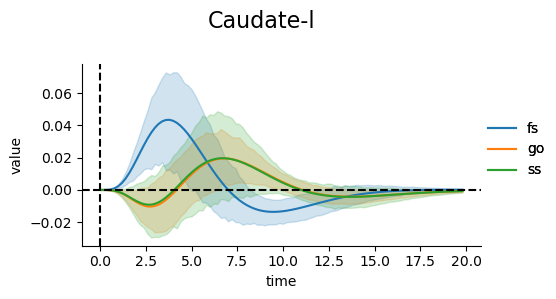

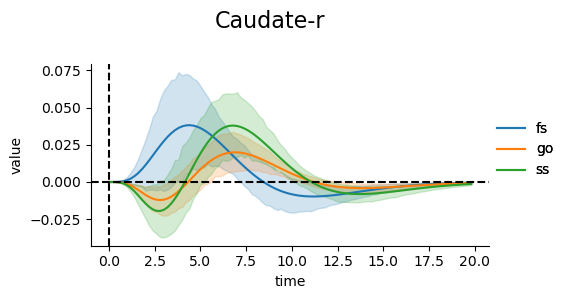

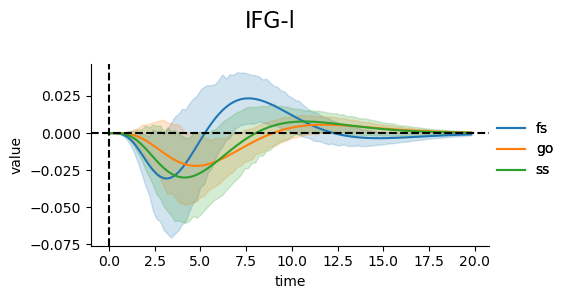

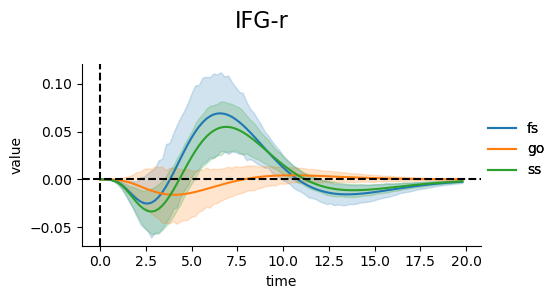

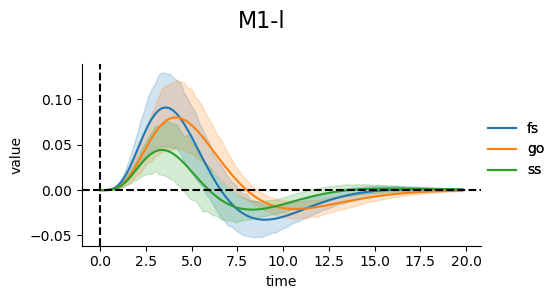

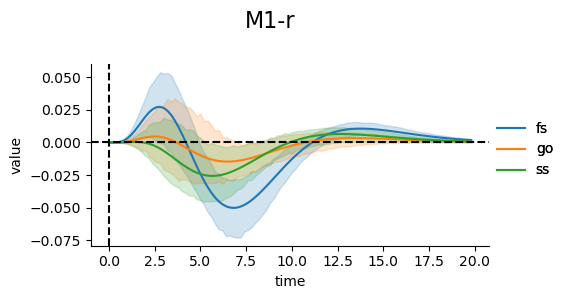

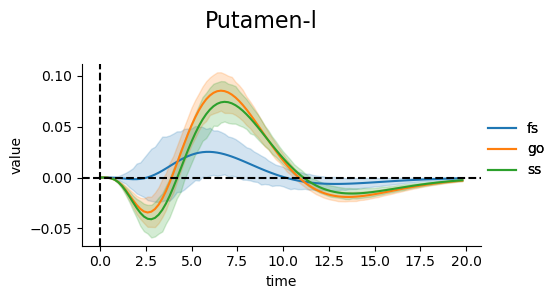

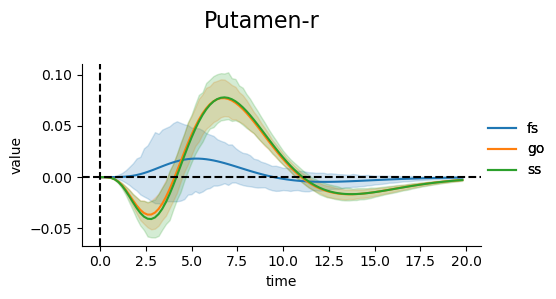

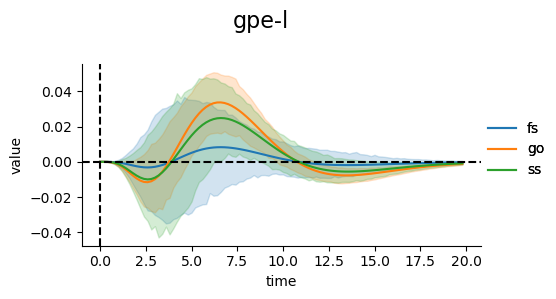

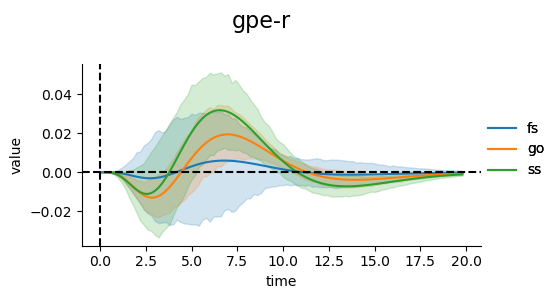

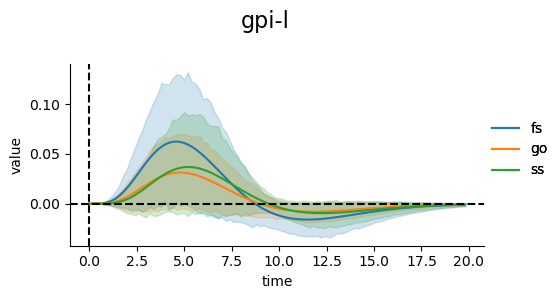

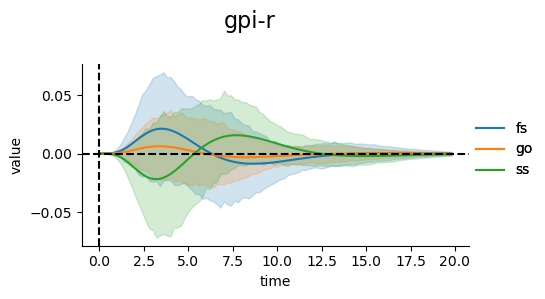

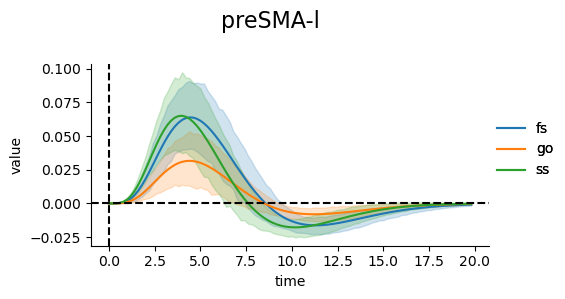

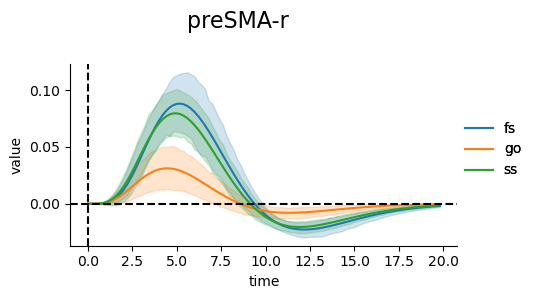

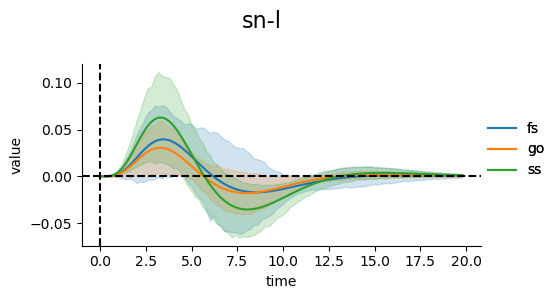

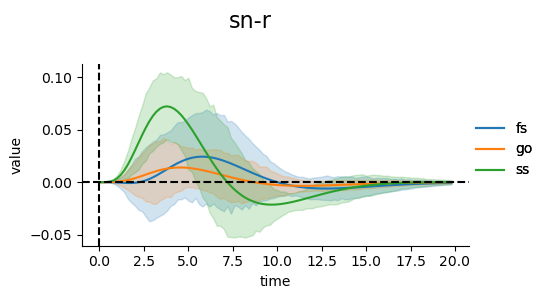

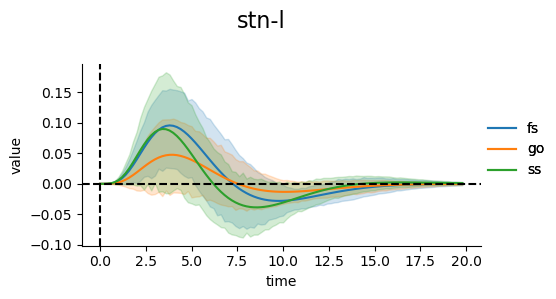

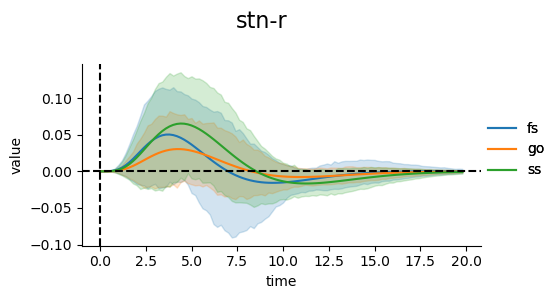

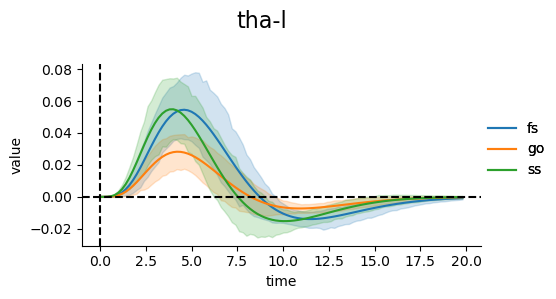

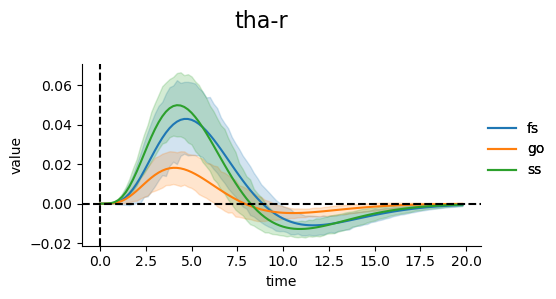

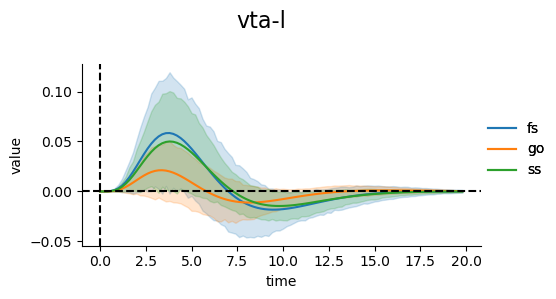

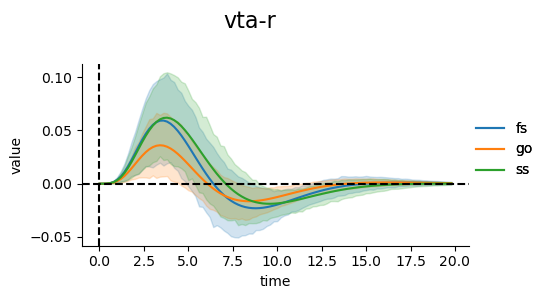

In [21]:
glm1.plot_groupwise_timecourses()

## plotting

In [52]:
import copy

glm1_ar1 = copy.deepcopy(glm1)
# glm1_ar1 = copy.deepcopy(glm_m)

tc = glm1.get_subjectwise_timecourses()
tc = tc.reset_index().melt(id_vars=['subject', 'event type', 'covariate', 'time'], var_name='roi', value_name='signal')

In [53]:
# # motor
# all_betas = glm_m.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
# subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
# subjectwise_betas = subjectwise_betas.loc[(slice(None),['response_left', 'response_right'], 'intercept', 'HRF')] # Select only betas of interest

# contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference right - left
# contrast_betas = contrast_betas.xs('response_right',level=1)
# contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_right-left', ignore_index=False)

# if atlas_type == 'ATAG':
#     contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
#     contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
# else:
#     contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
#     contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])

# ## recode to contralateral vs ipsilateral
# contrast_betas['beta_contra-ipsi'] = contrast_betas['beta_right-left'].copy()
# contrast_betas.loc[contrast_betas.hemisphere == 'r', 'beta_contra-ipsi'] *= -1
# contrast_betas_motor = contrast_betas.copy()

## event glms
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe

# fs - go
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference fs - go
contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsgo = contrast_betas.copy()

# ss - fs
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['ss', 'fs'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference fs - ss
contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-ss', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_fsss = contrast_betas.copy()

# go - ss
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go', 'ss'], 'intercept', 'HRF')]              # Select only betas of interest
# subjectwise_betas[['STN-l', 'STN-r', 'Str-l', 'Str-r']].melt(ignore_index=False).reset_index().to_csv('./download-for-steven/betas_SAT.csv')

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference ss - go
contrast_betas = contrast_betas.xs('ss',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ss-go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
contrast_betas_ssgo = contrast_betas.copy()

##########
###########
###########
# now look just at absolute activtions with trial types
############

# fs
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline fs
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_fs = contrast_betas.copy()

# ss
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['ss'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline ss
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_ss', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_ss = contrast_betas.copy()

# go
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
subjectwise_betas = subjectwise_betas.loc[(slice(None),['go'], 'intercept', 'HRF')]              # Select only betas of interest

contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True)#.groupby(level=0).diff()                   # Take against baseline go
# contrast_betas = contrast_betas.xs('fs',level=1)
contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_go', ignore_index=False)
if atlas_type == 'ATAG':
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
else:
    contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
    contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
betas_go = contrast_betas.copy()

contrast_betas_fsgo.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/contrast_betas_fsgo.tsv',sep='\t', index=True,header =True)
contrast_betas_fsss.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/contrast_betas_fsss.tsv',sep='\t', index=True,header =True)
contrast_betas_ssgo.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/contrast_betas_ssgo.tsv',sep='\t', index=True,header =True)

# look at significance

In [54]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# absolute activation

In [55]:
tmp = betas_fs.groupby('ROI')['beta_fs'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fs = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_ss.groupby('ROI')['beta_ss'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_ss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = betas_go.groupby('ROI')['beta_go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_go = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_fs, stat_ss, stat_go = stat_fs.reindex(rois_), stat_ss.reindex(rois_), stat_go.reindex(rois_)

In [56]:
display_side_by_side(stat_fs,stat_ss,stat_go, titles=['fs','ss','go'])

,t,p,fdr_significant,p_corrected,significance
IFG-l,1.243601,0.235606,False,0.326825,
IFG-r,3.010570,0.010033,True,0.02341,*
SMA-l,7.250625,0.000006,True,0.00009,***
SMA-r,4.928957,0.000276,True,0.000772,***
M1-l,5.027994,0.000231,True,0.000772,***
M1-r,-0.129082,0.899269,False,0.899269,
SN-l,1.604106,0.132699,False,0.232223,
SN-r,1.297009,0.217176,False,0.326825,
STN-l,2.107577,0.055050,False,0.1101,
STN-r,1.186148,0.256791,False,0.326825,


# contrast significance

In [57]:
tmp = contrast_betas_fsgo.groupby('ROI')['beta_fs-go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fsgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_fsss.groupby('ROI')['beta_fs-ss'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_fsss = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

tmp = contrast_betas_ssgo.groupby('ROI')['beta_ss-go'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)
stat_df['significance'] = ''
stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
stat_ssgo = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

# tmp = contrast_betas_motor.groupby('ROI')['beta_contra-ipsi'].apply(lambda x: scipy.stats.ttest_1samp(x, 0))
# stat_df = pd.DataFrame.from_dict(dict(zip(tmp.index, tmp.values)), orient='index', columns=['t', 'p']).reindex(rois_)
# stat_df = pd.concat([stat_df, pd.DataFrame(statsmodels.stats.multitest.fdrcorrection(stat_df['p'], method='i'), index=['fdr_significant', 'p_corrected'], columns=stat_df.index).T], axis=1)

# stat_df['significance'] = ''
# stat_df.loc[stat_df['p_corrected']<=0.05,'significance']='*'
# stat_df.loc[stat_df['p_corrected']<=0.01,'significance']='**'
# stat_df.loc[stat_df['p_corrected']<=0.001,'significance']='***'
# # stat_df.loc[stat_df['p_corrected']<=0.0001,'significance']='****'
# stat_leftright = stat_df.loc[sorted(stat_df.index, key=str.casefold)]

stat_fsgo, stat_fsss, stat_ssgo = stat_fsgo.reindex(rois_), stat_fsss.reindex(rois_), stat_ssgo.reindex(rois_)

stat_fsgo.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/stat_fsgo.tsv',sep='\t', index=True,header =True)
stat_fsss.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/stat_fsss.tsv',sep='\t', index=True,header =True)
stat_ssgo.to_csv(f'/home/scotti/projects/3t_7t_sst_comparison/derivatives/roi_glm/{dataset}/stat_ssgo.tsv',sep='\t', index=True,header =True)

In [58]:
display_side_by_side(stat_fsss,stat_fsgo,stat_ssgo, titles=['fs > ss','fs > go','ss > go'])

,t,p,fdr_significant,p_corrected,significance
IFG-l,2.466099,0.028342,False,0.132263,
IFG-r,1.270497,0.226175,False,0.462281,
SMA-l,2.758839,0.016261,False,0.113826,
SMA-r,1.086062,0.297180,False,0.462281,
M1-l,4.275985,0.000903,True,0.012636,*
M1-r,0.904987,0.381938,False,0.534713,
SN-l,-0.295054,0.772612,False,0.794416,
SN-r,-1.774094,0.099456,False,0.325797,
STN-l,1.116092,0.284588,False,0.462281,
STN-r,-0.611251,0.551573,False,0.643501,


## plot all 4 contrasts

In [59]:
import numpy as np
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m+h # only need highest 

def mean_confidence_interval_lower(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    #return m, m-h, m+h
    return m-h # only need highest 

def add_asteriks(ax_n, data, col_name, significance=0):
    l_count, r_count = 0, 0
    
    
#     new = contrast_betas_inccon.groupby(['ROI_nohemi','hemisphere'])['beta_inc-con'].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     new = new.loc[sorted(new.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval).reset_index().set_index('ROI_nohemi')
#     roi_data = roi_data.loc[sorted(roi_data.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data = roi_data.loc[roi_data.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
    roi_data_lower = data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval_lower).reset_index().set_index('ROI_nohemi')
#     roi_data_lower = roi_data_lower.loc[sorted(roi_data_lower.index,key=str.casefold)].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere'])
    roi_data_lower = roi_data_lower.loc[roi_data_lower.index].drop_duplicates().reset_index().set_index(['ROI_nohemi','hemisphere']).reindex(gm_nuclei,level=0)
    
#     print(roi_data_lower)
#     for index, (y_val, region) in enumerate(zip(data.groupby(['ROI_nohemi','hemisphere'])[col_name].apply(mean_confidence_interval), data.ROI.unique())):
    for index, (y_val, region, y_val_lower) in enumerate(zip(roi_data[col_name], data.ROI.unique(), roi_data_lower[col_name])):
#         print(significance)
#         print(region)
        if index%2 == 0:
            x_val = -0.26 + l_count
            l_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        else:
            x_val = 0.14 + r_count
            r_count+=1
            if (aster:=len(significance[index])) == 2:
                x_val = x_val - 0.06
            elif aster == 3:
                x_val = x_val - 0.12
        if y_val >= 0:
            ax[ax_n].text(x_val, y_val+0.005, significance[index])
        else:
            ax[ax_n].text(x_val, y_val_lower-0.017, significance[index])

/tmp/ipykernel_1801650/2872392783.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


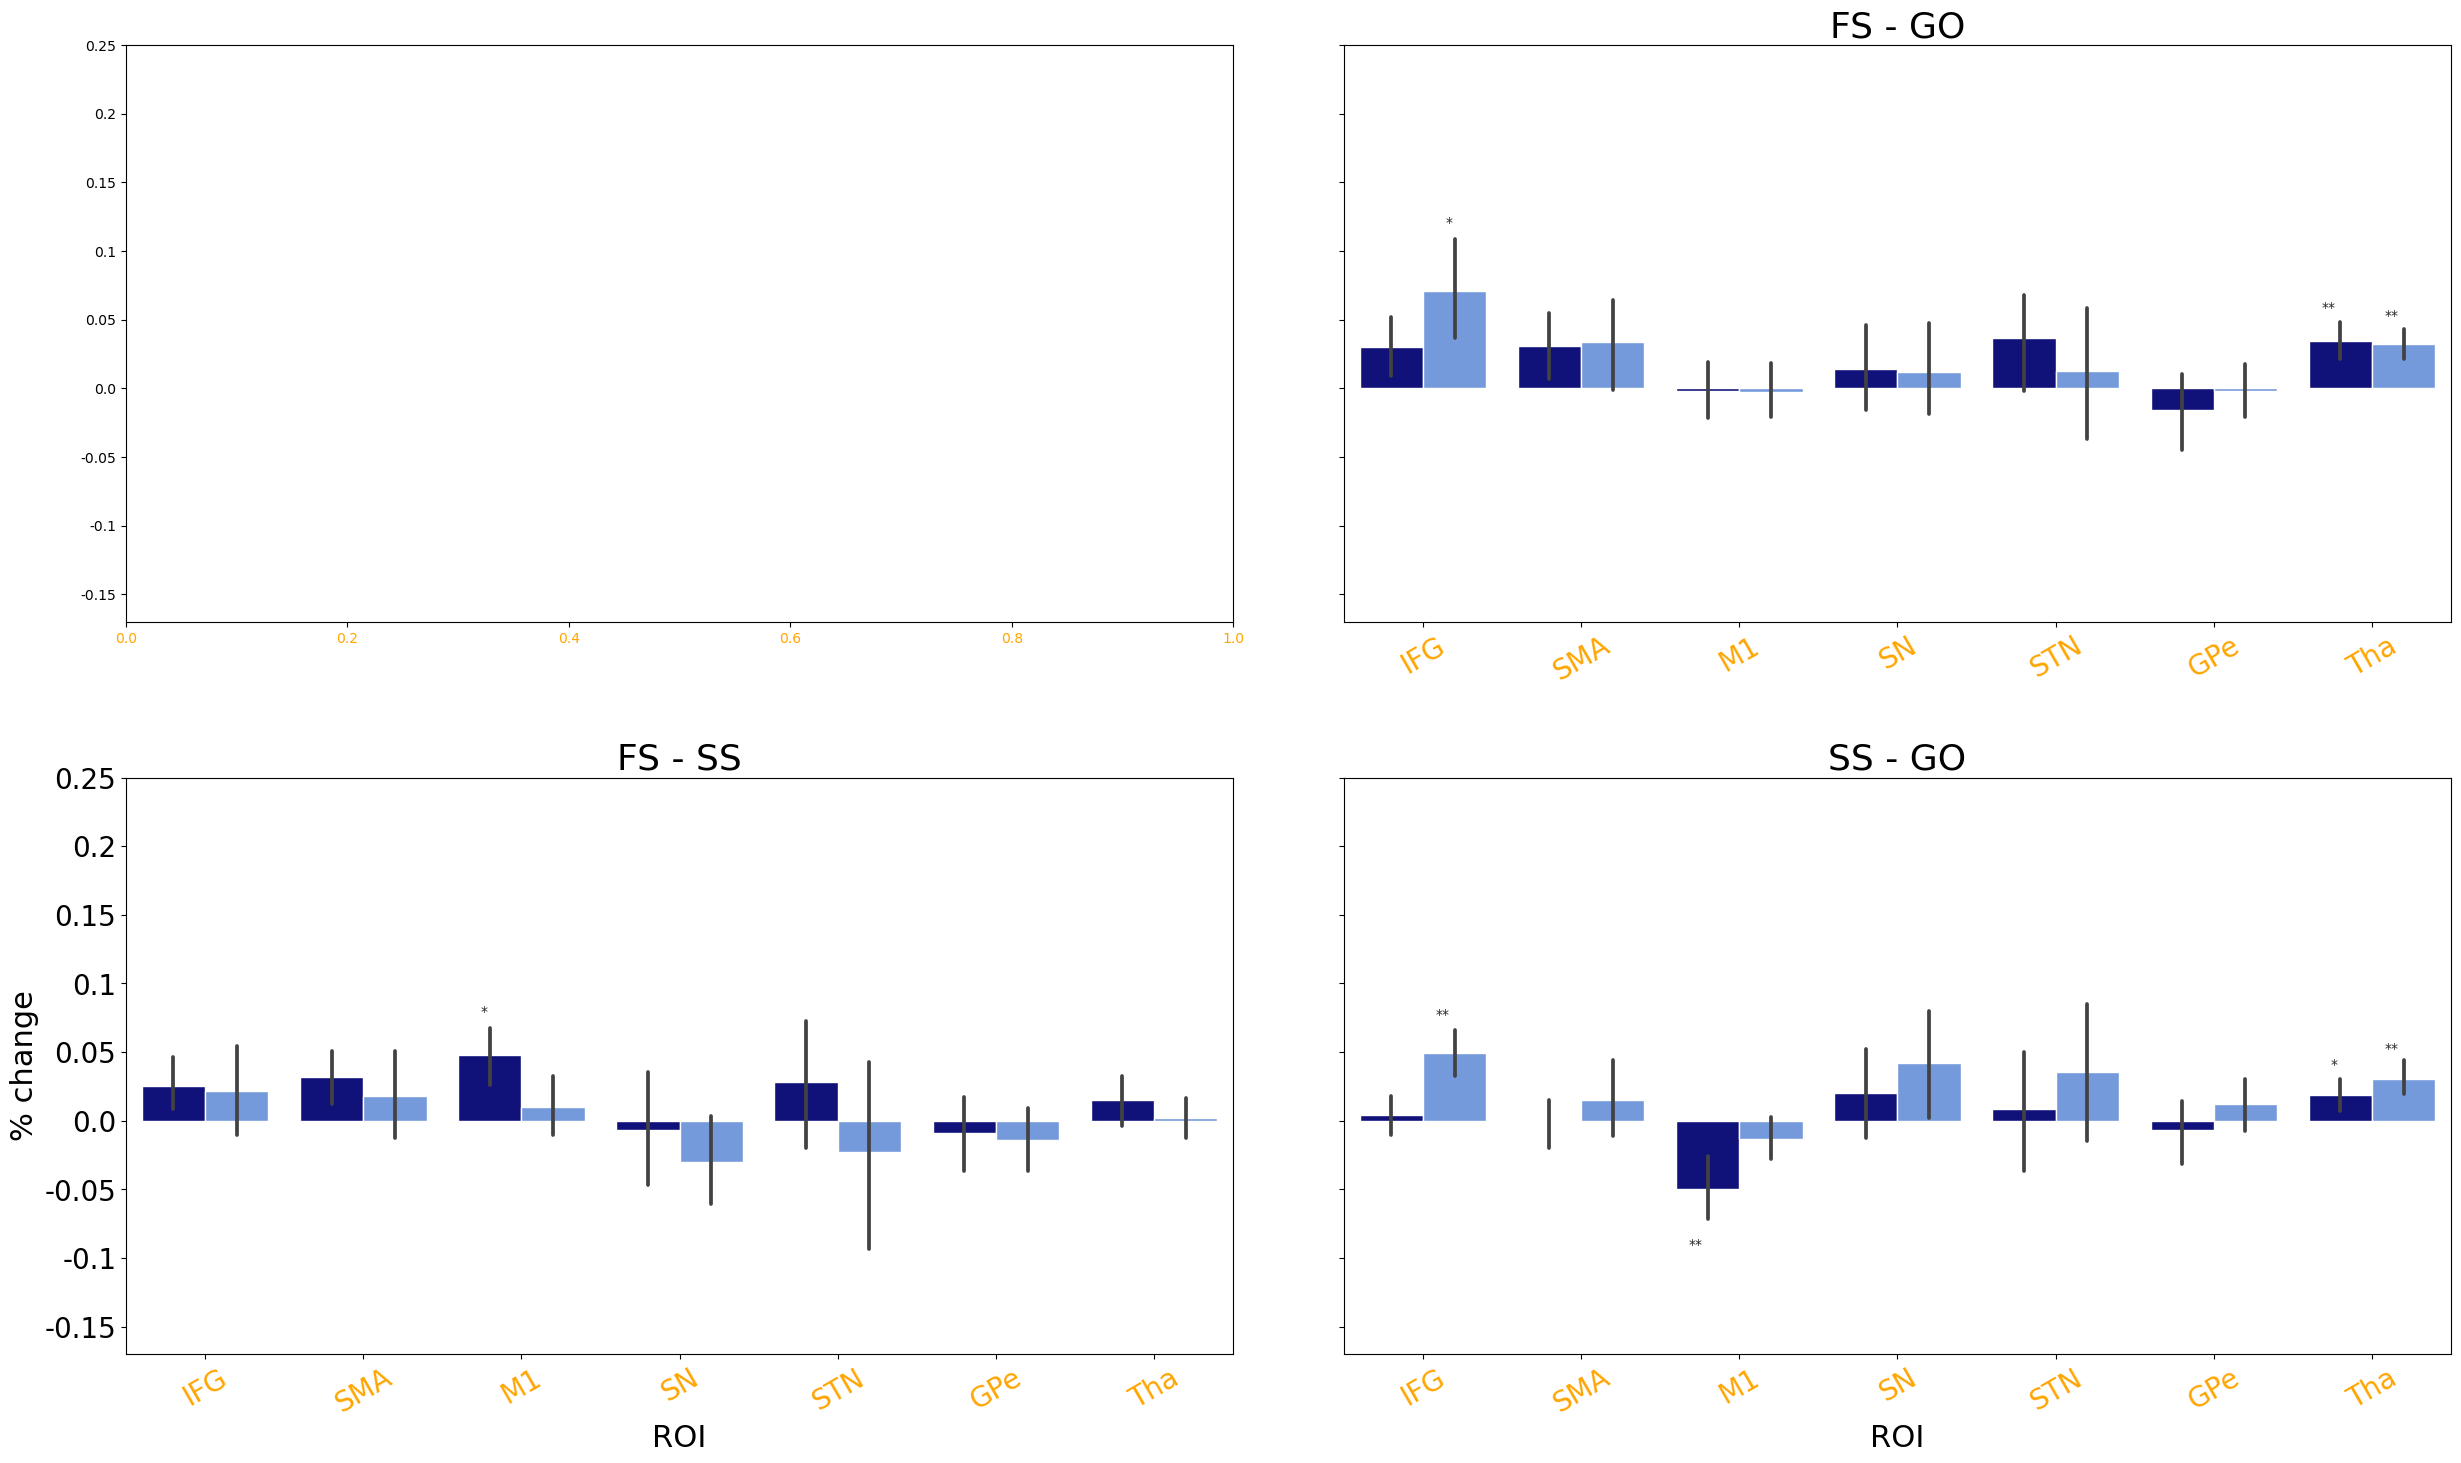

In [60]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

#     # 1 ## MOTOR RESPONSE
#     sns.barplot(x='ROI_nohemi', y='beta_contra-ipsi', hue='hemisphere', 
#                 data=contrast_betas_motor, ax=ax[0],palette=("darkblue","cornflowerblue"))
#     ax[0].set_ylabel('% change', fontsize=22)
#     ax[0].set_xlabel('')
#     ax[0].legend_.remove()
#     ax[0].set_title('Contralateral - ipsilateral', fontsize=26)
#     ax[0].set(ylim=(-0.17,0.25))
#     add_asteriks(0, contrast_betas_motor, 'beta_contra-ipsi', stat_leftright['significance'])
#     # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
#     ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
#     ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)


    ## 2
    sns.barplot(x='ROI_nohemi', y='beta_fs-go', hue='hemisphere', 
                data=contrast_betas_fsgo, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('FS - GO', fontsize=26)
    ax[1].set(ylim=(-0.17,0.25))
    add_asteriks(1, contrast_betas_fsgo, 'beta_fs-go', stat_fsgo['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[1].set_yticklabels(ax[1].get_yticks().round(2),fontsize=20)

    ## 3
    sns.barplot(x='ROI_nohemi', y='beta_fs-ss', hue='hemisphere', 
                data=contrast_betas_fsss, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('ROI', fontsize=22)
    ax[2].legend_.remove()
    ax[2].set_title('FS - SS', fontsize=26)
    ax[2].set(ylim=(-0.17,0.25))
    add_asteriks(2, contrast_betas_fsss, 'beta_fs-ss', stat_fsss['significance'])
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)

    ## 4
    sns.barplot(x='ROI_nohemi', y='beta_ss-go', hue='hemisphere', 
                data=contrast_betas_ssgo, ax=ax[3],palette=("darkblue","cornflowerblue"))
    ax[3].set_ylabel('')
    ax[3].set_xlabel('ROI', fontsize=22)
    ax[3].legend_.remove()
    ax[3].set_title('SS - GO', fontsize=26)
    ax[3].set(ylim=(-0.17,0.25))
    add_asteriks(3, contrast_betas_ssgo, 'beta_ss-go', stat_ssgo['significance'])
    ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation = 30,fontsize=20)
    # ax[3].set_yticklabels(ax[3].get_yticks().round(2),fontsize=20)

    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]

#     f.savefig('figure_download_scott/GLM_ROI_SST_contrasts.pdf', bbox_inches='tight')

/tmp/ipykernel_1801650/287470094.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
/tmp/ipykernel_1801650/287470094.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)


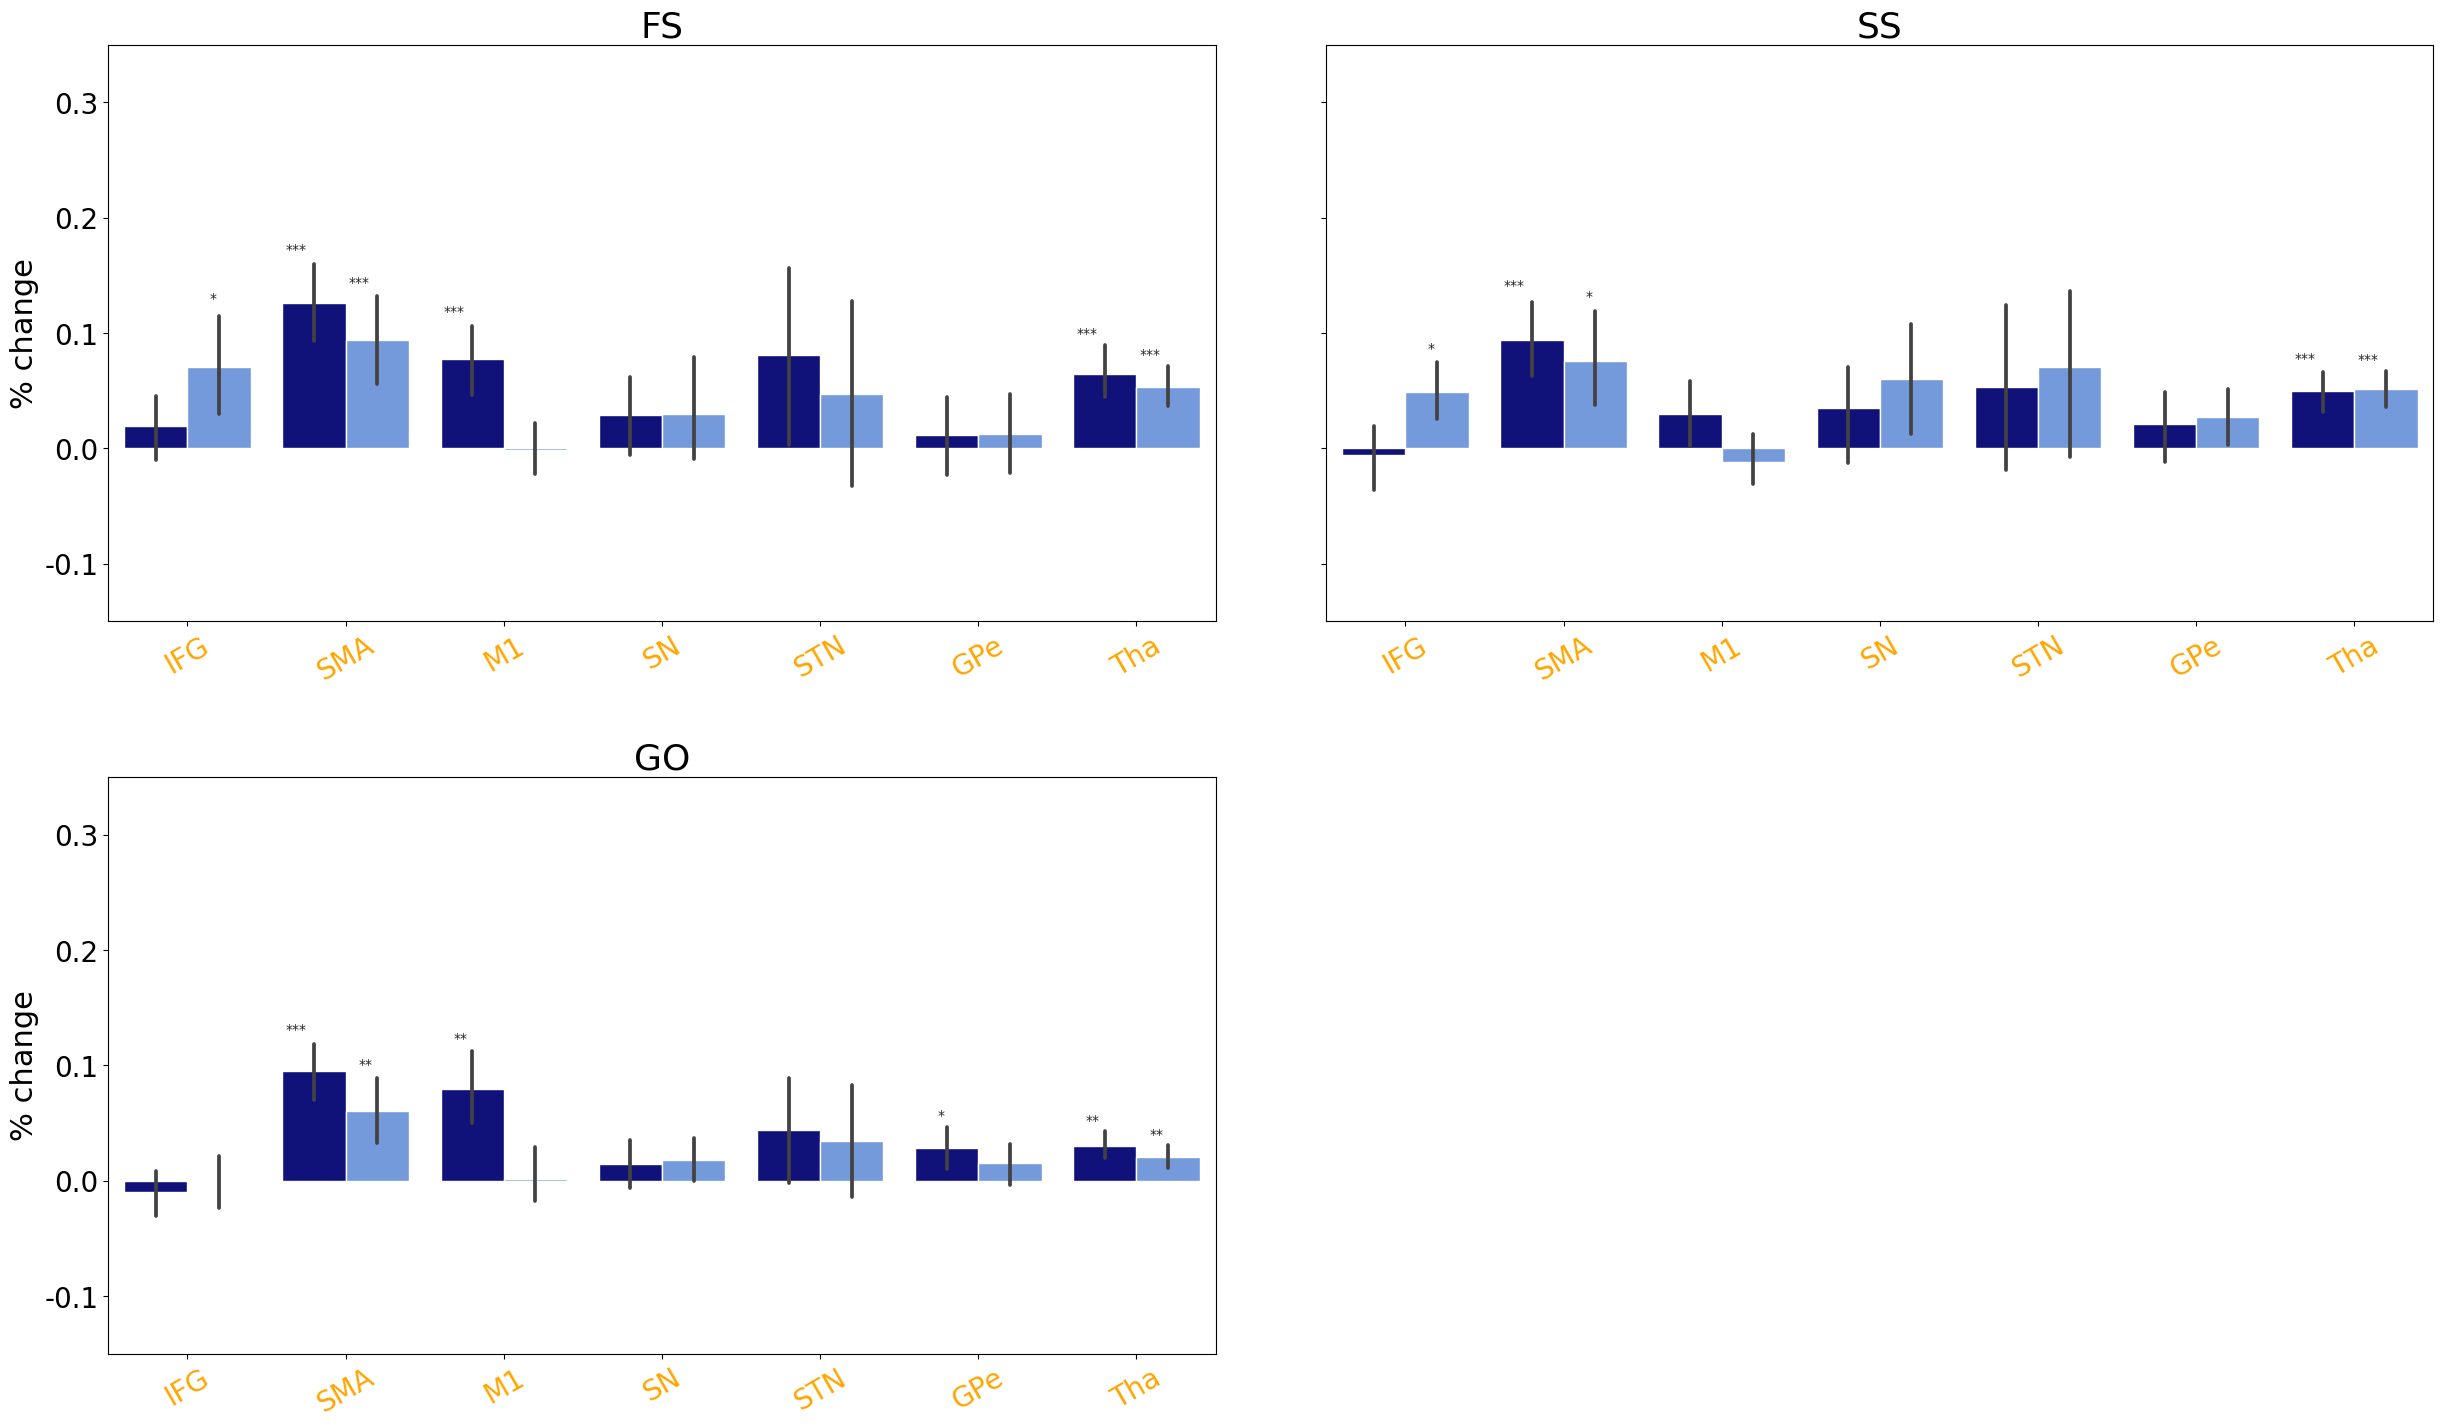

In [40]:
f, axes = plt.subplots(2,2, figsize=(30,17), sharex=False,sharey=True)
ax = axes.ravel()
f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.27)
# sns.set_style('darkgrid')

with sns.axes_style("whitegrid"):

    ## 1 ## FS
    sns.barplot(x='ROI_nohemi', y='beta_fs', hue='hemisphere', 
                data=betas_fs, ax=ax[0],palette=("darkblue","cornflowerblue"))
    ax[0].set_ylabel('% change', fontsize=22)
    ax[0].set_xlabel('')
    ax[0].legend_.remove()
    ax[0].set_title('FS', fontsize=26)
    ax[0].set(ylim=(-0.15,0.35))
    add_asteriks(0, betas_fs, 'beta_fs', stat_fs['significance'])
    # ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)
    ax[0].set_yticklabels(ax[0].get_yticks().round(2),fontsize=20)
    ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation = 30,fontsize=20)

    ## 2 SS
    sns.barplot(x='ROI_nohemi', y='beta_ss', hue='hemisphere', 
                data=betas_ss, ax=ax[1],palette=("darkblue","cornflowerblue"))
    ax[1].set_ylabel('')
    ax[1].set_xlabel('')
    ax[1].legend_.remove()
    ax[1].set_title('SS', fontsize=26)
    ax[1].set(ylim=(-0.15,0.35))
    add_asteriks(1, betas_ss, 'beta_ss', stat_ss['significance'])
    ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation = 30,fontsize=20)

    ## 3 GO
    sns.barplot(x='ROI_nohemi', y='beta_go', hue='hemisphere', 
                data=betas_go, ax=ax[2],palette=("darkblue","cornflowerblue"))
    ax[2].set_ylabel('% change', fontsize=22)
    ax[2].set_xlabel('', fontsize=22)
    ax[2].legend_.remove()
    ax[2].set_title('GO', fontsize=26)
    ax[2].set(ylim=(-0.15,0.35))
    add_asteriks(2, betas_go, 'beta_go', stat_go['significance'])
    # ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    ax[2].set_yticklabels(ax[2].get_yticks().round(2),fontsize=20)
    ax[2].set_xticklabels(ax[2].get_xticklabels(),rotation = 30,fontsize=20)
    
    for x in range(4) :[t.set_color(i) for (i,t) in zip(['orange']*7+['red']*8,ax[x].get_xticklabels())]
        
    ax[3].set_visible(False)
    
#     f.savefig('figure_download_scott/GLM_ROI_SST_supplementary.pdf', bbox_inches='tight')

In [25]:
# load and save glm info for model based analysis
# absolute values for FS, SS and GO trials for each region
all_betas = glm1.response_fitters.groupby(['subject', 'run']).apply(lambda x: x.iloc[0].betas)                   # Extract all betas to dataframe
subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
fs_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest
ss_betas = subjectwise_betas.loc[(slice(None),['ss'], 'intercept', 'HRF')]              # Select only betas of interest
go_betas = subjectwise_betas.loc[(slice(None),['go'], 'intercept', 'HRF')]              # Select only betas of interest

# fs_betas.to_csv('scott/fs_betas_tsv.tsv',sep='\t')
# ss_betas.to_csv('scott/ss_betas_tsv.tsv',sep='\t')
# go_betas.to_csv('scott/go_betas_tsv.tsv',sep='\t')
# fs_reg = 



# # fs - go
# subjectwise_betas = all_betas.groupby(level=[0,2,3,4]).mean()                                                    # Mean across runs (fixed-effects)
# subjectwise_betas = subjectwise_betas.loc[(slice(None),['fs'], 'intercept', 'HRF')]              # Select only betas of interest

# contrast_betas = subjectwise_betas.reset_index(level=[2,3], drop=True).groupby(level=0).diff()                   # Take difference SPD-ACC
# contrast_betas = contrast_betas.xs('fs',level=1)
# contrast_betas = contrast_betas.melt(var_name='ROI', value_name='beta_fs-go', ignore_index=False)
# if atlas_type == 'ATAG':
#     contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[0])
#     contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[1:])
# else:
#     contrast_betas['hemisphere'] = contrast_betas['ROI'].apply(lambda x: x[-1])
#     contrast_betas['ROI_nohemi'] = contrast_betas['ROI'].apply(lambda x: x[:-2])
# contrast_betas_fsgo = contrast_betas.copy()